<a href="https://colab.research.google.com/github/carolinehagood/ds4002-project3/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import requests
from io import BytesIO
import gzip
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
#Downloading url images
file_urls = ['https://github.com/carolinehagood/ds4002-project3/raw/refs/heads/main/data/n02085936-Maltese_dog.csv.gz',
             'https://github.com/carolinehagood/ds4002-project3/raw/refs/heads/main/data/n02088364-beagle.csv.gz',
             'https://github.com/carolinehagood/ds4002-project3/raw/refs/heads/main/data/n02099601-golden_retriever.csv.gz',
             'https://github.com/carolinehagood/ds4002-project3/raw/refs/heads/main/data/n02106662-German_shepherd.csv.gz',
             'https://github.com/carolinehagood/ds4002-project3/raw/refs/heads/main/data/n02110958-pug.csv.gz']
data_frames = []
for url in file_urls:
    response = requests.get(url)
    compressed_file = BytesIO(response.content)  # Create a BytesIO object
    with gzip.open(compressed_file, 'rt') as f:  # Open it as a text file
        df = pd.read_csv(f)  # Read the CSV file into a DataFrame
        data_frames.append(df)

In [ ]:
# Combine all DataFrames into a single DataFrame
data_df = pd.concat(data_frames, ignore_index=True)

# Print the DataFrame to check
print(data_df.head(1))

         0         1         2         3         4         5         6  \
0  0.07451  0.070588  0.054902  0.066667  0.062745  0.047059  0.070588   

          7        8        9  ...    49144     49145     49146    49147  \
0  0.066667  0.05098  0.12549  ...  0.32549  0.301961  0.368627  0.34902   

      49148     49149     49150     49151  breed             breed_name  
0  0.321569  0.380392  0.364706  0.321569      0  n02085936-Maltese_dog  

[1 rows x 49154 columns]


In [ ]:
if data_df['breed_name'].value_counts()['n02085936-Maltese_dog'] > 100:
    data_df = data_df.drop(
        data_df[data_df['breed_name'] == 'n02085936-Maltese_dog'].iloc[100:].index
    )

In [ ]:
data_df['breed_name'] = data_df['breed_name'].str.split('-').str[1]

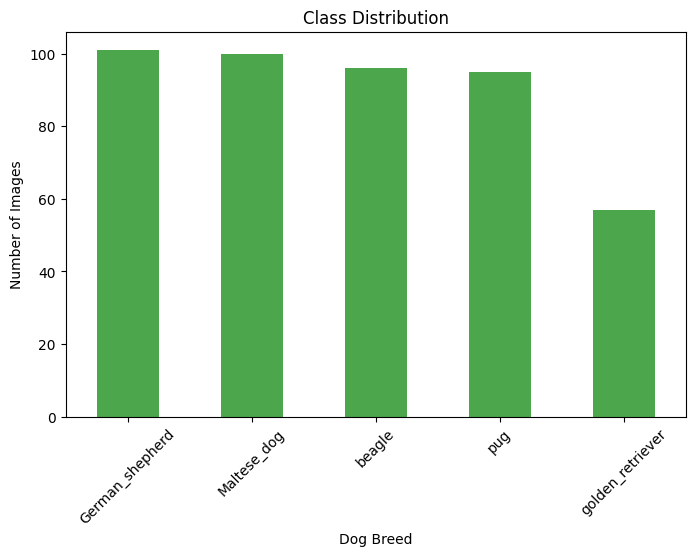

In [ ]:
#class distribution
import matplotlib.pyplot as plt

# Count the number of samples per breed
class_counts = data_df['breed_name'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='green', alpha=0.7)
plt.title("Class Distribution")
plt.xlabel("Dog Breed")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

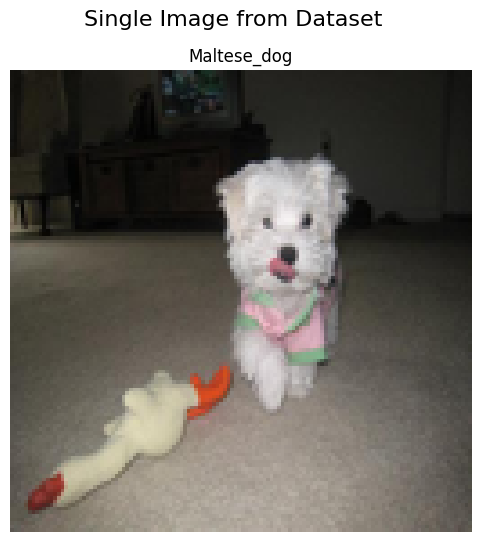

In [ ]:
#sample image visualization

# Define the correct dimensions for the image
image_dim = (128, 128, 3)  # If the actual size is 128x128
image_data = data_df.iloc[0, :-2].values.astype('float32').reshape(image_dim)

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image_data)
plt.title(data_df['breed_name'].iloc[0])  # Display the breed name as the title
plt.axis("off")
plt.suptitle("Single Image from Dataset", fontsize=16)
plt.show()

In [ ]:
#Image Mean and Standard Deviation per Breed

breed_counts = data_df['breed'].value_counts()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate mean and std dev per breed
def get_mean_std_for_breed(breed_data):
    flattened_data = breed_data.values.reshape(len(breed_data), -1)  # Flatten each image
    mean = np.mean(flattened_data, axis=1)  # Mean of pixel values for each image
    std = np.std(flattened_data, axis=1)  # Standard deviation of pixel values for each image
    return np.mean(mean), np.mean(std)  # Return the average mean and std for the breed


<ipython-input-15-37ac2d8b8981>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  breed_stats = data_df.groupby('breed').apply(lambda x: get_mean_std_for_breed(x.iloc[:, :-2]))


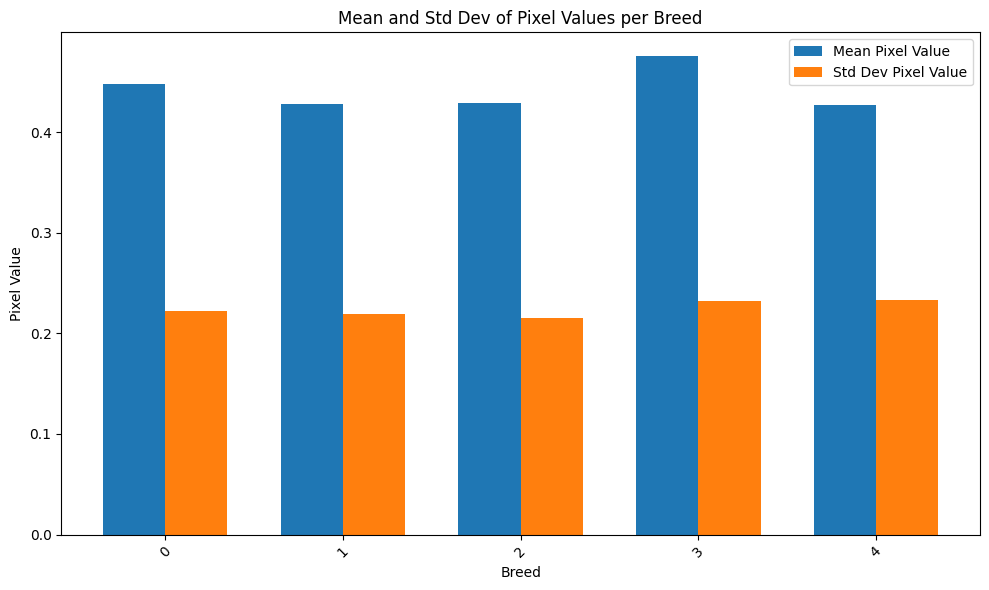

In [ ]:
# Ensure that we handle varying image counts correctly
breed_stats = data_df.groupby('breed').apply(lambda x: get_mean_std_for_breed(x.iloc[:, :-2]))

# Unpack the results into separate mean and std arrays
mean_values = breed_stats.apply(lambda x: x[0])
std_values = breed_stats.apply(lambda x: x[1])

# Plotting
plt.figure(figsize=(10, 6))
breeds = breed_stats.index
bar_width = 0.35
x = np.arange(len(breeds))


# Bar chart with mean and std dev values
plt.bar(x - bar_width / 2, mean_values, bar_width, label='Mean Pixel Value')
plt.bar(x + bar_width / 2, std_values, bar_width, label='Std Dev Pixel Value')

plt.xlabel('Breed')
plt.ylabel('Pixel Value')
plt.title('Mean and Std Dev of Pixel Values per Breed')
plt.xticks(x, breeds, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(data_df['breed'].unique())  # Check unique values
print(data_df['breed'].isna().sum())  # Check for NaN values

[0 1 2 3 4]
0


In [ ]:
# Ensure breed is an integer column (convert if needed)
data_df['breed'] = data_df['breed'].astype(int)

In [ ]:
X = data_df.iloc[:, :-2].values  # All columns except the last two
print(X.shape)

(449, 49152)


In [ ]:
y = data_df['breed'].values  # Labels are from the 'breed' column
print(y.shape)

(449,)


In [ ]:
# Set constants

IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS = 128, 128, 3
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 5  #number of dog breeds

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Normalize X
X = X / 255.0  # Scale pixel values to [0, 1]

# Reshape X to (height, width, channels) for 128x128 images
X = X.reshape(-1, 128, 128, 3)  # 128x128 images with 3 color channels (RGB)


# Encode labels (y) into integers and then one-hot encode
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [ ]:
#build cnn model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Load the pre-trained VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))

# Freeze the layers of the base model so they are not trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = Flatten()(base_model.output)  # Flatten the output of the base model
x = Dense(256, activation='relu')(x)  # Add a dense layer
x = Dropout(0.5)(x)  # Dropout layer for regularization
x = Dense(128, activation='relu')(x)  # Add another dense layer
x = Dropout(0.5)(x)  # Dropout for regularization

# Output layer for classification
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=32),  # Augmented training data
    validation_data=(X_test, y_test),  # Validation data
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 104s 9s/step - accuracy: 0.1813 - loss: 2.2758 - val_accuracy: 0.2111 - val_loss: 1.6180
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - accuracy: 0.2361 - loss: 1.6313 - val_accuracy: 0.2556 - val_loss: 1.5884
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - accuracy: 0.1991 - loss: 1.6789 - val_accuracy: 0.2111 - val_loss: 1.6016
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.2433 - loss: 1.6035 - val_accuracy: 0.2556 - val_loss: 1.6053
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.2012 - loss: 1.6055 - val_accuracy: 0.1444 - val_loss: 1.6065
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 164s 10s/step - accuracy: 0.1785 - loss: 1.6078 - val_accuracy: 0.2667 - val_loss: 1.6024
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.1874 - loss: 1.6048 - val_accuracy: 0.1444 - val_loss: 1.6020
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.2211 - loss: 1.6049 - val_accuracy: 0.1444 - val_loss: 1.600

In [ ]:
#unfreeze some layers of the pre-trained base model (fine-tuning)
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers of the VGG16 base model
    layer.trainable = True

# Step 3: Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # Use a lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Continue training (fine-tuning)
history_finetune = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=32),  # Augmented training data
    validation_data=(X_test, y_test),  # Validation data
    epochs=20,  # Continue for additional epochs
    initial_epoch=history.epoch[-1],  # Continue from the last trained epoch
    callbacks=[early_stopping]
)



Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 115s 9s/step - accuracy: 0.2362 - loss: 1.6061 - val_accuracy: 0.2556 - val_loss: 1.6023
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 106s 9s/step - accuracy: 0.2602 - loss: 1.6028 - val_accuracy: 0.2556 - val_loss: 1.6023
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.1741 - loss: 1.6055 - val_accuracy: 0.2556 - val_loss: 1.6022
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 109s 9s/step - accuracy: 0.2443 - loss: 1.6049 - val_accuracy: 0.2556 - val_loss: 1.6022
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 106s 9s/step - accuracy: 0.2195 - loss: 1.6035 - val_accuracy: 0.2556 - val_loss: 1.6022


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 11s/step - accuracy: 0.2332 - loss: 1.6021
Test Accuracy: 25.56%
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        19
           4       0.26      1.00      0.41        23

    accuracy                           0.26        90
   macro avg       0.05      0.20      0.08        90
weighted avg       0.07      0.26      0.10        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


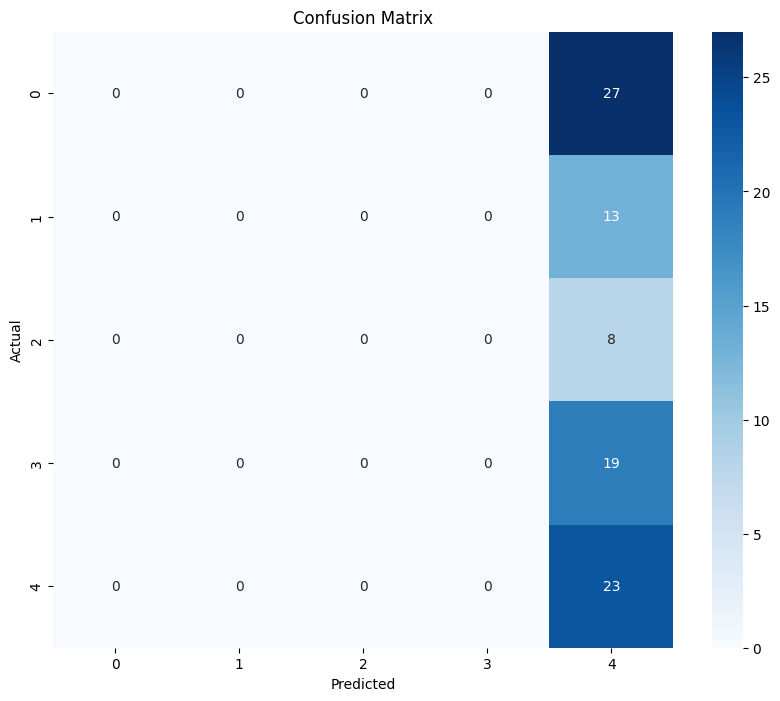

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[str(cls) for cls in label_encoder.classes_])) # Convert label_encoder.classes_ elements to strings

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(cls) for cls in label_encoder.classes_], yticklabels=[str(cls) for cls in label_encoder.classes_]) # Convert label_encoder.classes_ elements to strings for xticklabels and yticklabels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()